## Homework 3: Imbalanced Datasets

### Instructions:
Please upload the *.ipynb* AND *.pdf* to Gradescope prior to the deadline (03/26). Submission on Courseworks/Canvas is **not** required, and won't be accepted.

Please name your soltution file in the following format - AML_HW3_Solutions_(YOUR_UNI)


### GIST:
The goal of this assignment is to build a model that can reliably predict whether a client will subscribe to this term deposit based on their demographics and previous contact details from the Bank csv. You will notice that, without much effort, you can build a model that gives you a very high ‘accuracy’ score. However, this metric is misleading since the model cannot correctly classify instances of the minority class (‘1’ in this case). This can be attributed to the  inherent imbalance present in the target column of the dataset.  

To solve this issue, you will need to employ certain ML techniques that are designed to counter class imbalance. Hence, the focus of this assignment will be towards addressing class imbalance and testing the model using different evaluation metrics other than just accuracy.


## Name: Raksha Chandrashekar

## UNI: rc3729


In [42]:
#libraries
#Import below any other packages you need for your solution
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, roc_curve, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, auc
import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as imb_make_pipeline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Read the dataset
df = pd.read_csv('/content/drive/MyDrive/AML/HW3/bank-data.csv')
df.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### **1. Examining Class Imbalance.**

a. Examine the class imbalance in the target column. What is its class distribution? Show this information visually using an appropriate scale. </br>
b. What is the degree of imbalance? (Mild/Moderate/Extreme)

Class Distribution:  y
no     36548
yes     4640
Name: count, dtype: int64


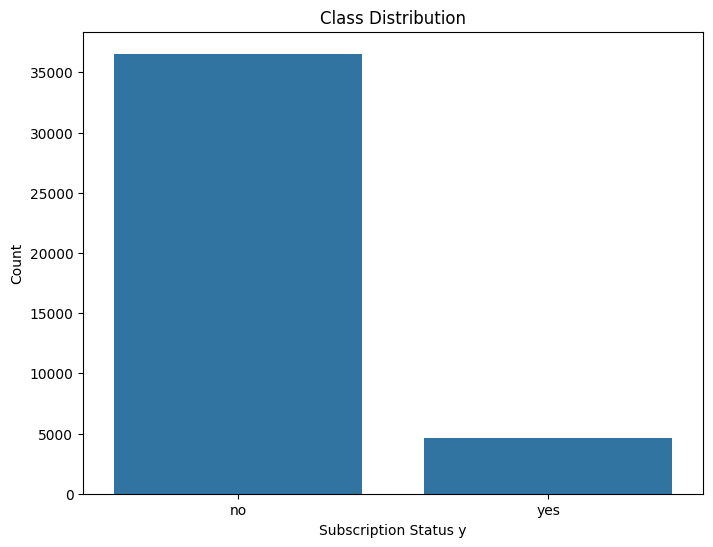

In [4]:
#Your code here
count = df['y'].value_counts()
print("Class Distribution: ", count)

plt.figure(figsize=(8, 6))
sns.barplot(x=count.index, y=count.values)
plt.xlabel('Subscription Status y')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [5]:
#Your code here
imbalance_ratio = count.max()/count.min()
print("Imbalance Ratio: ", imbalance_ratio)

if imbalance_ratio<=1.5:
  print("Degree of Imbalance: Mild")
elif imbalance_ratio<=3:
  print("Degree of Imbalance: Moderate")
else:
  print("Degree of Imbalance: Extreme")

Imbalance Ratio:  7.876724137931035
Degree of Imbalance: Extreme


The degree of imbalance is **extreme** as 'no' class has over 35000 data samples whereas the 'yes' class has about 5000 samples.

### **2. Pre-processing**


a. Split the dataset into development and test sets. What splitting methodology did you choose, and why? </br>
b. Encode the categorical variables. </br>
c. Scale numerical columns. </br>
d. Encode the target variable. </br>
e. Print the shape of the development and test set.

In [6]:
#Your code here
# a.
X = df.drop(columns=['y'])
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(32950, 20) (8238, 20) (32950,) (8238,)


## Comment
Stratified Splitting Technique is used to split since the dataset is highly imbalanced and we want to ensure same proportions of both the majority and minority classes in the splits.

In [7]:
#Your code here
# b.
categorical_columns = X_train.select_dtypes(include=['object']).columns
label_encoder = {}
for col in categorical_columns:
  le = LabelEncoder()
  X_train[col] = le.fit_transform(X_train[col])
  X_test[col] = le.transform(X_test[col])
  label_encoder[col] = le

In [8]:
#Your code here
# c.
scaler = StandardScaler()
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [9]:
#Your code here
# d.
y_train = y_train.map({'no': 0, 'yes': 1})
y_test = y_test.map({'no': 0, 'yes': 1})

print(y_train.isna().sum())

0


In [10]:
#Your code here
# e.
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Test target shape: {y_test.shape}")

Training set shape: (32950, 20)
Test set shape: (8238, 20)
Training target shape: (32950,)
Test target shape: (8238,)


Categorical features are encoded using Label Encoder as it is better suited for DecisionTrees and will help prevent feature explosion.<br>
Numerical features are scaled, as they have wide ranged values, using StandardScaler.<br>
The target variable 'y' is encoded so that the 'no' class is represented as 0 and the 'yes' class is represented as 1.

### 3.1 Default Dataset
Use the Decision tree classifier (use max_depth=10 and random_state=42) model and print the AUC and Average Precision values of 5 Fold Cross Validation </br>

In [28]:
#Your Code Here
default_clf = DecisionTreeClassifier(max_depth=10, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(default_clf, X_train, y_train, cv=cv, method='predict_proba')[:, 1]

auc_score = roc_auc_score(y_train, y_pred)
avg_precision = average_precision_score(y_train, y_pred)

print(f"AUC Score: {auc_score:.4f}")
print(f"Average Precision: {avg_precision:.4f}")

AUC Score: 0.8554
Average Precision: 0.5117


### 3.2 Balanced Weight

a. Here, we are going to use a 'balanced' decision tree clasifier on the same dataset. Use max_depth=10 and random_state=42, and then print the AUC and Average Precision values of 5 Fold Cross Validation.

In [29]:
#Your Code Here
balanced_clf = DecisionTreeClassifier(max_depth=10, random_state=42, class_weight='balanced')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(balanced_clf, X_train, y_train, cv=cv, method='predict_proba')[:, 1]

auc_score = roc_auc_score(y_train, y_pred)
avg_precision = average_precision_score(y_train, y_pred)

print(f"AUC Score: {auc_score:.4f}")
print(f"Average Precision: {avg_precision:.4f}")

AUC Score: 0.8797
Average Precision: 0.5555


### 3.3 Random Oversampling

a. Perform random oversampling on the development dataset. (Please set random state to 42 while doing this).
Examine the target column again. What is its class distribution now? Print the shape of the development set. </br>

b. Repeat part 3.1 again. Use the Decision tree classifier (use max_depth=10 and random_state=42) model and print the AUC and Average Precision values of 5 Fold Cross Validation

In [13]:
#Your Code Here
ros = RandomOverSampler(random_state=42)
X_train_resampled_ros, y_train_resampled_ros = ros.fit_resample(X_train, y_train)
print("Class Distribution after Random Oversampling: \n", y_train_resampled_ros.value_counts())
print(f"Training set shape after Random Oversampling: {X_train_resampled_ros.shape}")
print(f"Training target shape after Random Oversampling: {y_train_resampled_ros.shape}")

Class Distribution after Random Oversampling: 
 y
0    29238
1    29238
Name: count, dtype: int64
Training set shape after Random Oversampling: (58476, 20)
Training target shape after Random Oversampling: (58476,)


In [30]:
#Your Code Here
ros_clf = DecisionTreeClassifier(max_depth=10, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(ros_clf, X_train_resampled_ros, y_train_resampled_ros, cv=cv, method='predict_proba')[:, 1]

auc_score = roc_auc_score(y_train_resampled_ros, y_pred)
avg_precision = average_precision_score(y_train_resampled_ros, y_pred)

print(f"AUC Score after Random Oversampling: {auc_score:.4f}")
print(f"Average Precision after Random Oversampling: {avg_precision:.4f}")

AUC Score after Random Oversampling: 0.9543
Average Precision after Random Oversampling: 0.9307


### 3.4 Random Undersampling

a. Perform random undersampling on the development dataset. (Please set random state to 42 while doing this).
Examine the target column again. What is its class distribution now? Print the shape of the development set. </br>

b. Repeat part 3.1 again. Use the Decision tree classifier (use max_depth=10 and random_state=42) model and print the AUC and Average Precision values of 5 Fold Cross Validation

In [15]:
#Your Code Here
rus = RandomUnderSampler(random_state=42)
X_train_resampled_rus, y_train_resampled_rus = rus.fit_resample(X_train, y_train)
print("Class Distribution after Random Undersampling: \n", y_train_resampled_rus.value_counts())
print(f"Training set shape after Random Undersampling: {X_train_resampled_rus.shape}")
print(f"Training target shape after Random Undersampling: {y_train_resampled_rus.shape}")

Class Distribution after Random Undersampling: 
 y
0    3712
1    3712
Name: count, dtype: int64
Training set shape after Random Undersampling: (7424, 20)
Training target shape after Random Undersampling: (7424,)


In [31]:
#Your Code Here
rus_clf = DecisionTreeClassifier(max_depth=10, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(rus_clf, X_train_resampled_rus, y_train_resampled_rus, cv=cv, method='predict_proba')[:, 1]

auc_score = roc_auc_score(y_train_resampled_rus, y_pred)
avg_precision = average_precision_score(y_train_resampled_rus, y_pred)

print(f"AUC Score after Random Undersampling: {auc_score:.4f}")
print(f"Average Precision after Random Undersampling: {avg_precision:.4f}")

AUC Score after Random Undersampling: 0.8748
Average Precision after Random Undersampling: 0.8347


### 3.5 SMOTE

a. Perform Synthetic Minority Oversampling Technique (SMOTE) on the development dataset. (Please set random state to 42 while doing this). Examine the target column again. What is its class distribution now? Print the shape of the development set. </br>

b. Repeat part 3.1 again. Use the Decision tree classifier (use max_depth=10 and random_state=42) model and print the AUC and Average Precision values of 5 Fold Cross Validation

In [17]:
#Your Code Here
smote = SMOTE(random_state=42)
X_train_resampled_smote, y_train_resampled_smote = smote.fit_resample(X_train, y_train)
print("Class Distribution after SMOTE: \n", y_train_resampled_smote.value_counts())
print(f"Training set shape after SMOTE: {X_train_resampled_smote.shape}")
print(f"Training target shape after SMOTE: {y_train_resampled_smote.shape}")

Class Distribution after SMOTE: 
 y
0    29238
1    29238
Name: count, dtype: int64
Training set shape after SMOTE: (58476, 20)
Training target shape after SMOTE: (58476,)


In [32]:
#Your Code Here

smote_clf = DecisionTreeClassifier(max_depth=10, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(smote_clf, X_train_resampled_smote, y_train_resampled_smote, cv=cv, method='predict_proba')[:, 1]

auc_score = roc_auc_score(y_train_resampled_smote, y_pred)
avg_precision = average_precision_score(y_train_resampled_smote, y_pred)

print(f"AUC Score after SMOTE: {auc_score:.4f}")
print(f"Average Precision after SMOTE: {avg_precision:.4f}")

AUC Score after SMOTE: 0.9613
Average Precision after SMOTE: 0.9530


### 3.6 Visual Comparison

Prepare a plot comparing the class distribtion of the target column for each of the imbalance techiques used above. Use the default class split as well.

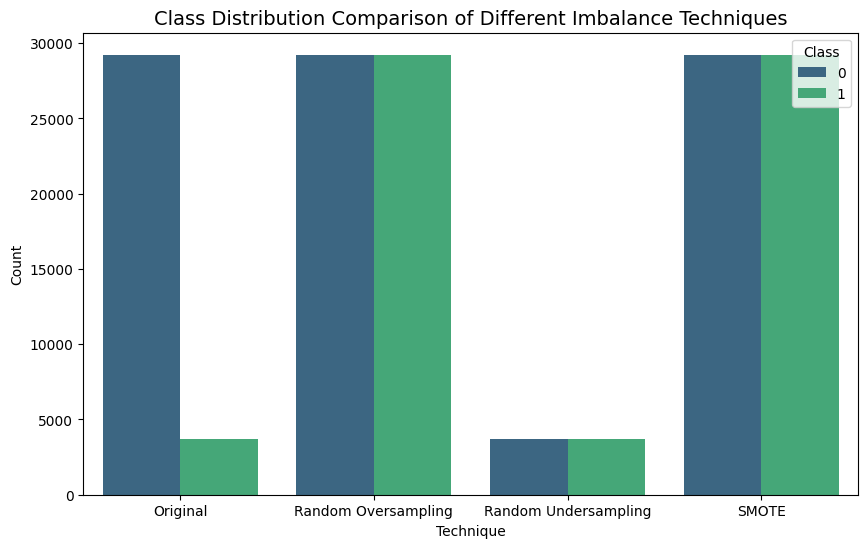

In [33]:
#Your Code Here
original_count = y_train.value_counts()
random_oversampling_count = y_train_resampled_ros.value_counts()
random_undersampling_count = y_train_resampled_rus.value_counts()
smote_count = y_train_resampled_smote.value_counts()

data = {
    'Technique': ['Original', 'Original', 'Random Oversampling', 'Random Oversampling',
                  'Random Undersampling', 'Random Undersampling', 'SMOTE', 'SMOTE'],
    'Class': [0, 1, 0, 1, 0, 1, 0, 1],
    'Count': [original_count[0], original_count[1], random_oversampling_count[0], random_oversampling_count[1],
              random_undersampling_count[0], random_undersampling_count[1], smote_count[0], smote_count[1]]
}
df = pd.DataFrame(data)
plt.figure(figsize=(10, 6))
sns.barplot(x='Technique', y='Count', hue='Class', data=df, palette='viridis')
plt.title('Class Distribution Comparison of Different Imbalance Techniques', fontsize=14)
plt.ylabel('Count')
plt.xlabel('Technique')
plt.show()

Balanced Weight Model is not included in the plot becuase it does not change the class distribution. It just changes the weights each class holds.

### **4.1: Model Prediction & Evaluation - AUC Scores**
Make predictions on the test set using the five models that you built and report their AUC values<br>
(Five models include models from - Default Baseline, Random Undersampling, Random Oversampling, SMOTE & Balanced Weight). Did the models with high AUC scores on the development set exhibit similar performance on the test set? Explain.

In [34]:
#Your Code Here
default_clf.fit(X_train, y_train)
default_pred = default_clf.predict_proba(X_test)[:, 1]

balanced_clf.fit(X_train, y_train)
balanced_pred = balanced_clf.predict_proba(X_test)[:, 1]

ros_clf.fit(X_train_resampled_ros, y_train_resampled_ros)
ros_pred = ros_clf.predict_proba(X_test)[:, 1]

rus_clf.fit(X_train_resampled_rus, y_train_resampled_rus)
rus_pred = rus_clf.predict_proba(X_test)[:, 1]

smote_clf.fit(X_train_resampled_smote, y_train_resampled_smote)
smote_pred = smote_clf.predict_proba(X_test)[:, 1]

default_auc = roc_auc_score(y_test, default_pred)
balanced_auc = roc_auc_score(y_test, balanced_pred)
ros_auc = roc_auc_score(y_test, ros_pred)
rus_auc = roc_auc_score(y_test, rus_pred)
smote_auc = roc_auc_score(y_test, smote_pred)

print(f"AUC Score for Default Baseline: {default_auc:.4f}")
print(f"AUC Score for Balanced Weight: {balanced_auc:.4f}")
print(f"AUC Score for Random Oversampling: {ros_auc:.4f}")
print(f"AUC Score for Random Undersampling: {rus_auc:.4f}")
print(f"AUC Score for SMOTE: {smote_auc:.4f}")

AUC Score for Default Baseline: 0.8920
AUC Score for Balanced Weight: 0.9060
AUC Score for Random Oversampling: 0.9022
AUC Score for Random Undersampling: 0.8967
AUC Score for SMOTE: 0.9153


## Comment

**Yes,** the models with high AUC scores in the development set (SMOTE) exhibited a similar behaviour with the test set, suggesting that the model generalizes well on the test data and reduces overfitting.<br>
SMOTE has the highest scores in both development and test sets compared to the others, followed by ROS and Balanced Weight models (test set).

### **4.2: Model Prediction & Evaluation - Confusion Matrix**
a. Plot Confusion Matrices for all the five models on the test set. Comment on your results and share in detail. Consider precision, recall and f1 scores. <br>
b. For the dataset at hand, which evaluation metric matters most according to you? Would it make sense to prioritise either precision/recall over the other? Justify.

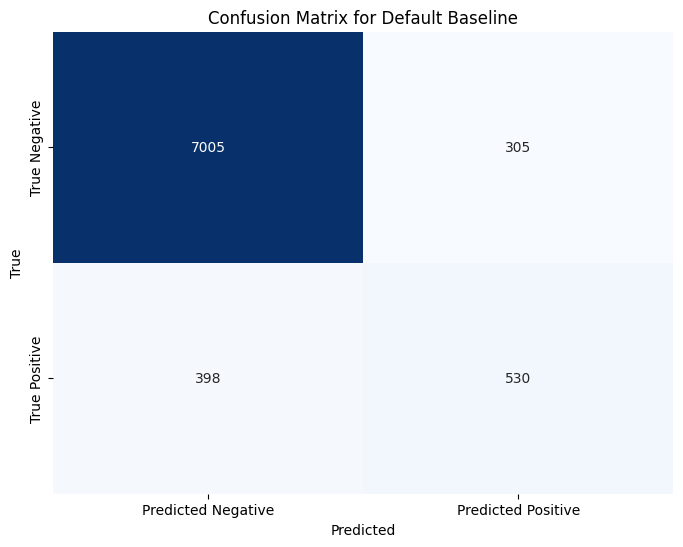

Default Baseline Precision: 0.6347
Default Baseline Recall: 0.5711
Default Baseline F1 Score: 0.6012


In [35]:
#Your Code Here
def confusion_matrix_plot(y_true, y_pred, model_name):
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'],
              yticklabels=['True Negative', 'True Positive'], cbar=False)
  plt.title(f'Confusion Matrix for {model_name}')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()


default_pred_class = default_clf.predict(X_test)
confusion_matrix_plot(y_test, default_pred_class, 'Default Baseline')
print(f"Default Baseline Precision: {precision_score(y_test, default_pred_class):.4f}")
print(f"Default Baseline Recall: {recall_score(y_test, default_pred_class):.4f}")
print(f"Default Baseline F1 Score: {f1_score(y_test, default_pred_class):.4f}")

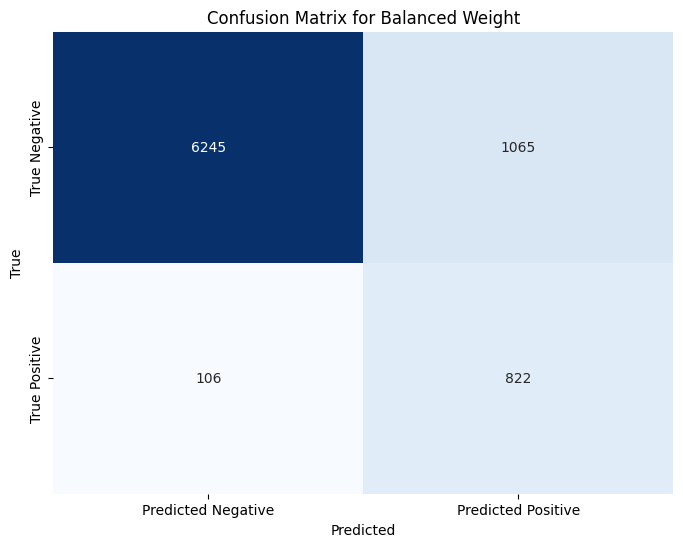

Balanced Weight Precision: 0.4356
Balanced Weight Recall: 0.8858
Balanced Weight F1 Score: 0.5840


In [36]:
#Your Code Here
balanced_pred_class = balanced_clf.predict(X_test)
confusion_matrix_plot(y_test, balanced_pred_class, 'Balanced Weight')
print(f"Balanced Weight Precision: {precision_score(y_test, balanced_pred_class):.4f}")
print(f"Balanced Weight Recall: {recall_score(y_test, balanced_pred_class):.4f}")
print(f"Balanced Weight F1 Score: {f1_score(y_test, balanced_pred_class):.4f}")

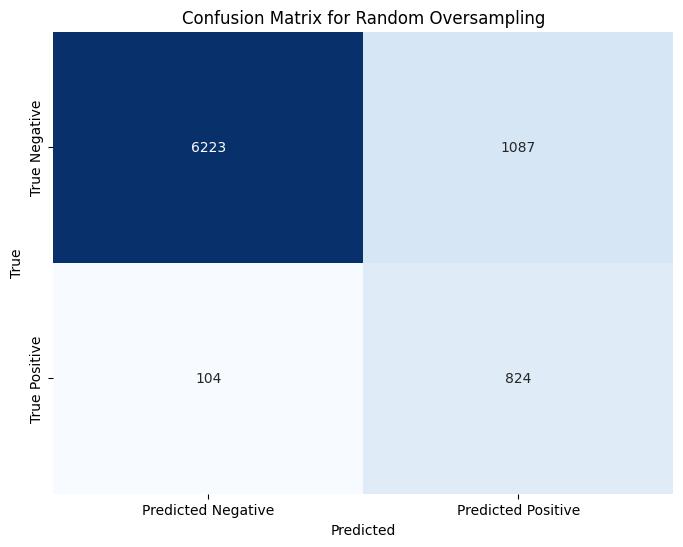

Random Oversampling Precision: 0.4312
Random Oversampling Recall: 0.8879
Random Oversampling F1 Score: 0.5805


In [37]:
#Your Code Here
ros_pred_class = ros_clf.predict(X_test)
confusion_matrix_plot(y_test, ros_pred_class, 'Random Oversampling')
print(f"Random Oversampling Precision: {precision_score(y_test, ros_pred_class):.4f}")
print(f"Random Oversampling Recall: {recall_score(y_test, ros_pred_class):.4f}")
print(f"Random Oversampling F1 Score: {f1_score(y_test, ros_pred_class):.4f}")

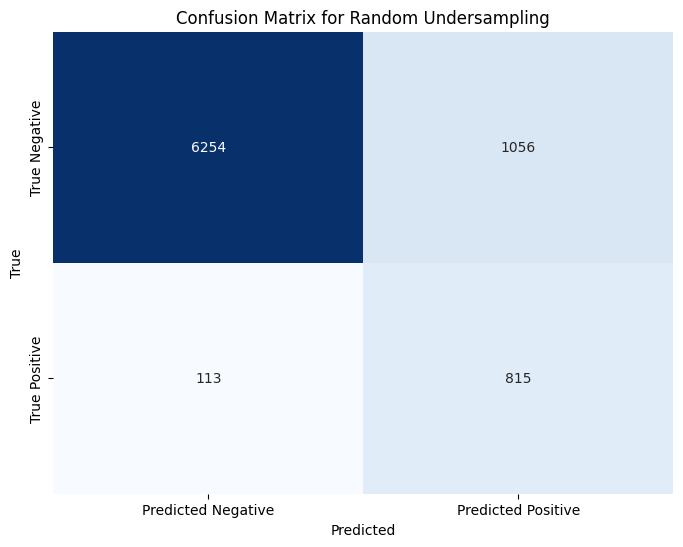

Random Undersampling Precision: 0.4356
Random Undersampling Recall: 0.8782
Random Undersampling F1 Score: 0.5824


In [38]:
#Your Code Here
rus_pred_class = rus_clf.predict(X_test)
confusion_matrix_plot(y_test, rus_pred_class, 'Random Undersampling')
print(f"Random Undersampling Precision: {precision_score(y_test, rus_pred_class):.4f}")
print(f"Random Undersampling Recall: {recall_score(y_test, rus_pred_class):.4f}")
print(f"Random Undersampling F1 Score: {f1_score(y_test, rus_pred_class):.4f}")

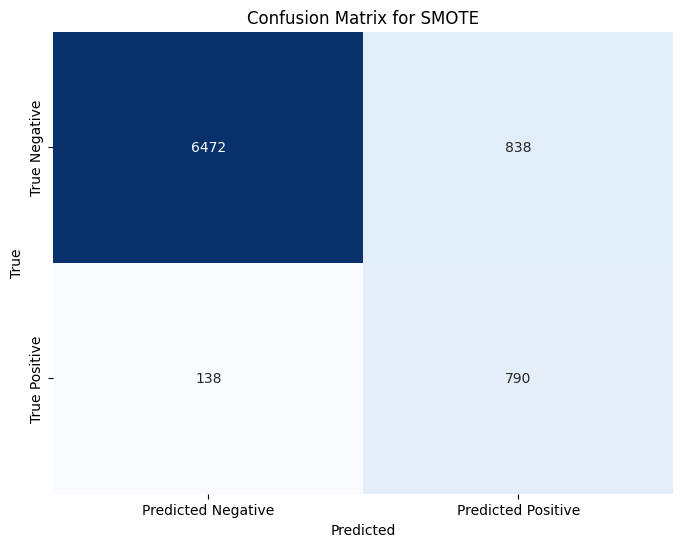

SMOTE Precision: 0.4853
SMOTE Recall: 0.8513
SMOTE F1 Score: 0.6182


In [39]:
#Your Code Here
smote_pred_class = smote_clf.predict(X_test)
confusion_matrix_plot(y_test, smote_pred_class, 'SMOTE')
print(f"SMOTE Precision: {precision_score(y_test, smote_pred_class):.4f}")
print(f"SMOTE Recall: {recall_score(y_test, smote_pred_class):.4f}")
print(f"SMOTE F1 Score: {f1_score(y_test, smote_pred_class):.4f}")

## Comment
SMOTE has the best overall performance compared to the other 4 techniques as it has a good balance between precision and recall and the highest F1-score.<br>
Balanced, oversampling, and undersampling models all have a higher recall than their respective precision. They focus more on False Negative cases and therefore prioritize recall<br>
SMOTE model is better when one wants to focus on False Positives (customers subscribing to the term deposit)<br>


b.<br>
There are different perspectives to be observed while choosing a metric:
- Recall should be prioritized if we want to target as many customers as possible and can afford some False Positives.
- Precision should be prioritized if we want to target the customers who are most likely to subscribe to the term deposit.
- If we want a balance between the above two scenarios, then F1-score is a better choice.

### **4.3: Model Prediction & Evaluation - ROC Curves**

Plot ROC for all the five models on the test set in a single plot. Recomment which technique is most appropriate and why.

<ipython-input-44-f6c414dc1c99>:26: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', lw=2, color='navy', linestyle='--')
<ipython-input-44-f6c414dc1c99>:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', lw=2, color='navy', linestyle='--')


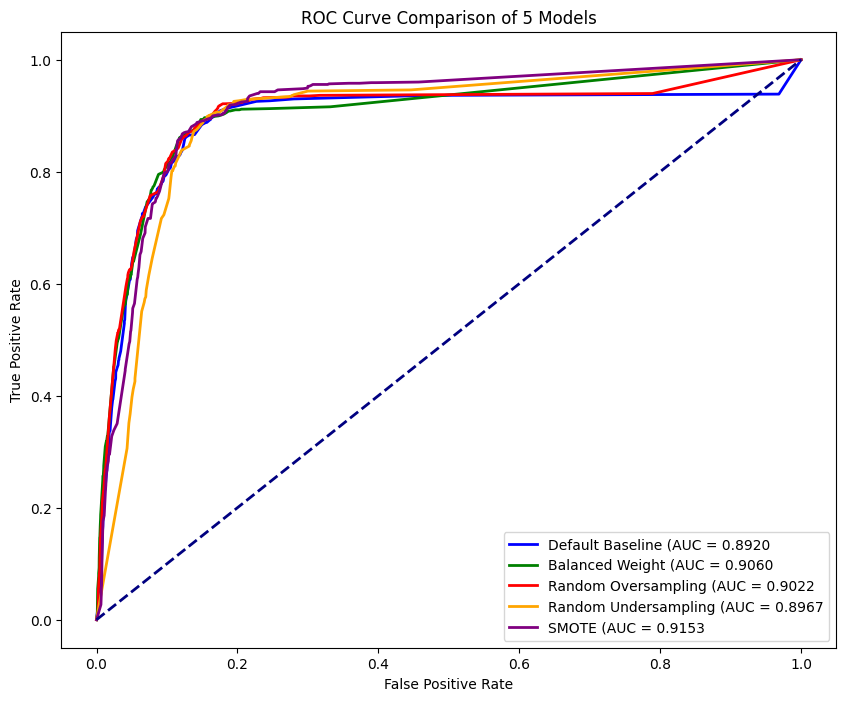

In [44]:
#Your Code Here
default_prob = default_clf.predict_proba(X_test)[:, 1]
balanced_prob = balanced_clf.predict_proba(X_test)[:, 1]
ros_prob = ros_clf.predict_proba(X_test)[:, 1]
rus_prob = rus_clf.predict_proba(X_test)[:, 1]
smote_prob = smote_clf.predict_proba(X_test)[:, 1]

fp_default, tp_default, _ = roc_curve(y_test, default_prob)
fp_balanced, tp_balanced, _ = roc_curve(y_test, balanced_prob)
fp_ros, tp_ros, _ = roc_curve(y_test, ros_prob)
fp_rus, tp_rus, _ = roc_curve(y_test, rus_prob)
fp_smote, tp_smote, _ = roc_curve(y_test, smote_prob)

roc_auc_default = auc(fp_default, tp_default)
roc_auc_balanced = auc(fp_balanced, tp_balanced)
roc_auc_ros = auc(fp_ros, tp_ros)
roc_auc_rus = auc(fp_rus, tp_rus)
roc_auc_smote = auc(fp_smote, tp_smote)

plt.figure(figsize=(10, 8))
plt.plot(fp_default, tp_default, label=f'Default Baseline (AUC = {roc_auc_default:.4f}', color='blue', lw=2)
plt.plot(fp_balanced, tp_balanced, label=f'Balanced Weight (AUC = {roc_auc_balanced:.4f}', color='green', lw=2)
plt.plot(fp_ros, tp_ros, label=f'Random Oversampling (AUC = {roc_auc_ros:.4f}', color='red', lw=2)
plt.plot(fp_rus, tp_rus, label=f'Random Undersampling (AUC = {roc_auc_rus:.4f}', color='orange', lw=2)
plt.plot(fp_smote, tp_smote, label=f'SMOTE (AUC = {roc_auc_smote:.4f}', color='purple', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=2, color='navy', linestyle='--')
plt.title('ROC Curve Comparison of 5 Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## Comment
SMOTE has the highest AUC score of 0.9153 compared to the other 4 models and is therefore is the most appropriate technique as it shows the best trade-off between False Positive and True Positive rates. This is also seen in the plot above where SMOTE is better than all the other models, followed by random undersampling, balanced weight, random oversampling and finally the baseline model.